# 第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [42]:
import pandas as pd
import numpy as np
import csv
import re
import gensim
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## 70. 単語ベクトルの和による特徴量

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2021-05-18 00:57:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  12.7MB/s    in 2.2s    

2021-05-18 00:57:14 (12.7 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [3]:
df = pd.read_table("newsCorpora.csv", header=None)
df.set_axis(['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'], axis=1, inplace=True)
df = df.set_index('ID')

extractPublisher = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df.loc[df['PUBLISHER'].isin(extractPublisher)]

df = df.sample(frac=1, random_state=42)
train, valid, test = np.split(df, [int(.8*len(df)), int(.9*len(df))])

In [4]:
def cat_convert(df,filename):
  cat_list_num = list(map(lambda x:{'b':0,
                               't':1,
                               'e':2,
                               'm':3}[x], df["CATEGORY"]))
  vec = torch.tensor(cat_list_num)
  torch.save(vec, filename)
  return vec

Ytrain = cat_convert(train, "Ytrain.pt")
Yvalid = cat_convert(valid, "Yvalid.pt")
Ytest = cat_convert(test, "Ytest.pt")

In [5]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [6]:
def preprocess(text):
  text = text.lower()
  text = re.sub(r"[.?!-/:;\"]",'',text)
  text = re.sub(r"[0-9]","",text)
  return text

def title_convert(df, filename):
  titles = df.TITLE
  title_processed = [preprocess(x) for x in titles]
  Xmatrix = []
  for title in title_processed:
      vec_list = [model[word] for word in title.split() if word in model]
      result = sum(vec_list)/len(vec_list)
      Xmatrix.append(result)
  matrix = torch.tensor(Xmatrix)
  torch.save(matrix, filename)
  return matrix

Xtrain = title_convert(train, "Xtrain.pt")
Xvalid = title_convert(valid, "Xvalid.pt")
Xtest = title_convert(test, "Xtest.pt")

## 71. 単層ニューラルネットワークによる予測

In [7]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
  
  def forward(self, x):
    x = self.fc(x)
    return x

In [8]:
nn_model = NeuralNetwork(300, 4)

In [9]:
x1 = Xtrain[0]
y1_hat = nn_model(x1)
y1_hat = F.softmax(y1_hat, dim=-1)

x1_4 = Xtrain[:4]
Y_hat = nn_model(x1_4)
Y_hat = F.softmax(Y_hat,dim=-1)

In [10]:
print("y1: ", y1_hat)
print("Y: ", Y_hat)

y1:  tensor([0.2419, 0.2522, 0.2348, 0.2711], grad_fn=<SoftmaxBackward>)
Y:  tensor([[0.2419, 0.2522, 0.2348, 0.2711],
        [0.2625, 0.2488, 0.2451, 0.2436],
        [0.2389, 0.2560, 0.2413, 0.2638],
        [0.2524, 0.2511, 0.2443, 0.2522]], grad_fn=<SoftmaxBackward>)


## 72. 損失と勾配の計算

In [11]:
loss = nn.CrossEntropyLoss()

print('x1')
loss_val = loss(nn_model(Xtrain[:1]), Ytrain[:1])
nn_model.zero_grad()
loss_val.backward()
print('loss: ',loss_val.item())
print('gradient: ', nn_model.fc.weight.grad)

print()

print('x1_4')
loss_val = loss(nn_model(Xtrain[:4]), Ytrain[:4])
nn_model.zero_grad()
loss_val.backward()
print('loss: ',loss_val.item())
print('gradient: ', nn_model.fc.weight.grad)

x1
loss:  1.4192713499069214
gradient:  tensor([[ 0.0273,  0.0264, -0.0035,  ...,  0.0063, -0.0375,  0.0251],
        [-0.0091, -0.0088,  0.0012,  ..., -0.0021,  0.0125, -0.0083],
        [-0.0084, -0.0082,  0.0011,  ..., -0.0020,  0.0116, -0.0078],
        [-0.0098, -0.0094,  0.0012,  ..., -0.0023,  0.0134, -0.0090]])

x1_4
loss:  1.3994581699371338
gradient:  tensor([[ 0.0048, -0.0236, -0.0077,  ..., -0.0074, -0.0201,  0.0404],
        [-0.0017,  0.0066, -0.0025,  ..., -0.0035,  0.0096, -0.0188],
        [-0.0011,  0.0105,  0.0123,  ...,  0.0146,  0.0008, -0.0025],
        [-0.0019,  0.0064, -0.0022,  ..., -0.0037,  0.0096, -0.0191]])


## 73. 確率的勾配降下法による学習

In [12]:
learning_rate = 0.01
n_iters = 100

optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
dataset = TensorDataset(Xtrain, Ytrain)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(n_iters):
  total_loss = 0
  for x, y in loader:
    optimizer.zero_grad()
    loss_value = loss(nn_model(x),y)
    loss_value.backward()
    optimizer.step()
    total_loss += loss_value.item()
  print(epoch, "Loss: ", total_loss/len(loader))

0 Loss:  0.744521116361813
1 Loss:  0.5353920723507923
2 Loss:  0.4729676305545734
3 Loss:  0.43956346202937097
4 Loss:  0.4184756614097913
5 Loss:  0.40349175034413587
6 Loss:  0.39209676700289453
7 Loss:  0.3831121045495772
8 Loss:  0.3757176704016865
9 Loss:  0.3694638192092766
10 Loss:  0.36404684409985727
11 Loss:  0.35948640039787333
12 Loss:  0.35542246287065565
13 Loss:  0.3516862743855099
14 Loss:  0.34825932614864036
15 Loss:  0.34530362209132864
16 Loss:  0.3425757029785437
17 Loss:  0.34019526229638775
18 Loss:  0.33767029249248504
19 Loss:  0.33556180829071364
20 Loss:  0.33365299504549384
21 Loss:  0.3316663839043582
22 Loss:  0.32974882594215094
23 Loss:  0.32828134535938774
24 Loss:  0.32676762212502947
25 Loss:  0.32523788096113443
26 Loss:  0.3238020889996901
27 Loss:  0.3226171728934495
28 Loss:  0.32117052102573396
29 Loss:  0.3202143739301046
30 Loss:  0.3189050384542965
31 Loss:  0.3176958969300011
32 Loss:  0.31697226239851084
33 Loss:  0.31590567682580645
34 Los

## 74. 正解率の計測

In [13]:
def acc(loader, model):
  sum_acc = 0
  for x, y in loader: 
    y_pred = nn_model(x)
    sum_acc += y_pred.argmax(1) == y
  return sum_acc/len(loader)

print('train accuracy: ',end='')
dataset = TensorDataset(Xtrain, Ytrain)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
print(acc(loader, model))

print('test accuracy: ',end='')
dataset = TensorDataset(Xtest, Ytest)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
print(acc(loader, model))

train accuracy: tensor([0.9033])
test accuracy: tensor([0.8913])


## 75. 損失と正解率のプロット

0.27338248563611217 tensor([0.9070])


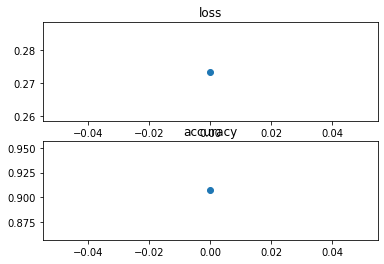

0.27329271375056263 tensor([0.9072])


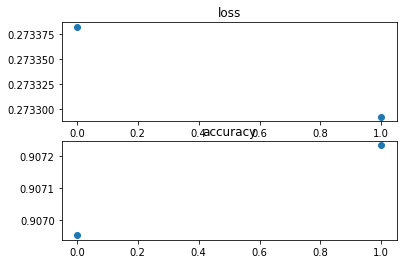

0.27328656440909266 tensor([0.9070])


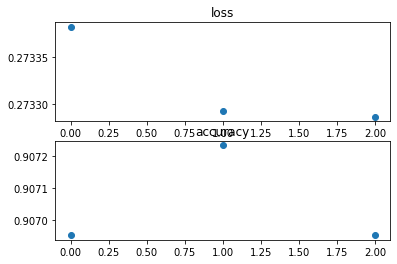

0.27326057423819766 tensor([0.9063])


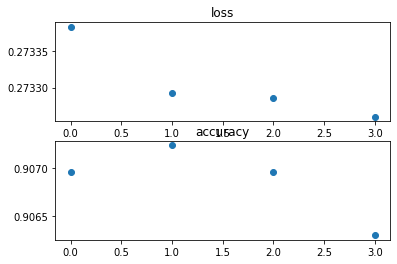

0.2732608192334867 tensor([0.9068])


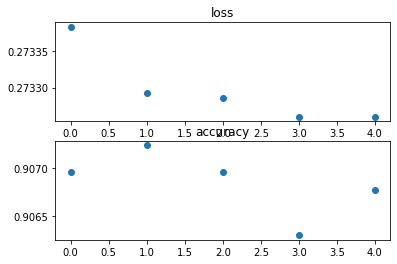

0.27312397697512314 tensor([0.9062])


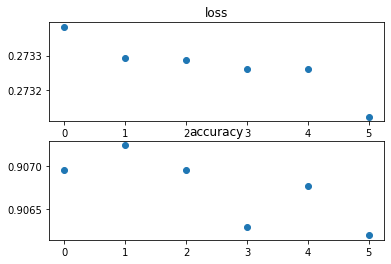

0.27313855499538714 tensor([0.9066])


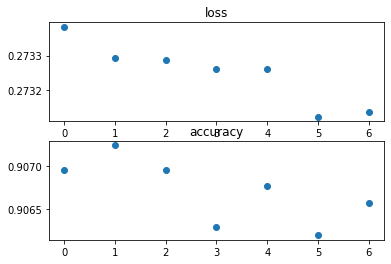

0.2731108066338525 tensor([0.9070])


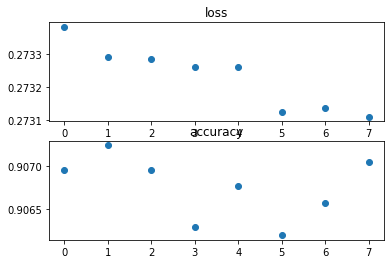

0.2731133659152043 tensor([0.9068])


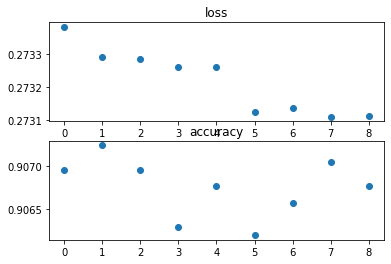

0.27312534503538866 tensor([0.9070])


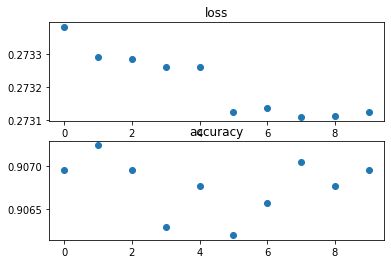

In [39]:
learning_rate = 0.01
n_iters = 10

optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
dataset = TensorDataset(Xtrain, Ytrain)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
loss_list = []
acc_list = []

for epoch in range(n_iters):
  total_loss = 0
  for x, y in loader:
    optimizer.zero_grad()
    loss_value = loss(nn_model(x),y)
    loss_value.backward()
    optimizer.step()
    total_loss += loss_value.item()
  loss_point = total_loss/len(loader)
  acc_point = acc(loader,model)
  loss_list.append(loss_point)
  acc_list.append(acc_point)
  
  # display output
  print(loss_point, acc_point)
  fig, axs = plt.subplots(2)
  axs[0].set_title('loss')
  axs[0].scatter(range(epoch+1), loss_list)
  axs[1].set_title('accuracy')
  axs[1].scatter(range(epoch+1), acc_list)
  plt.show()

## 76. チェックポイント

0.2730458385857182 tensor([0.9071])


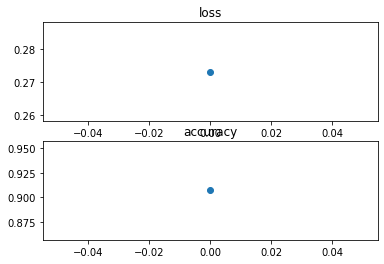

0.2730864576753285 tensor([0.9070])


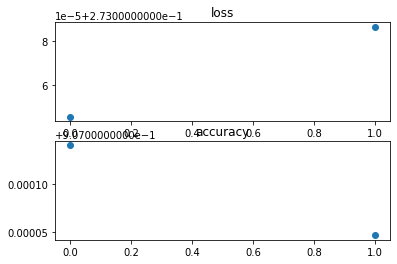

0.273045201430429 tensor([0.9070])


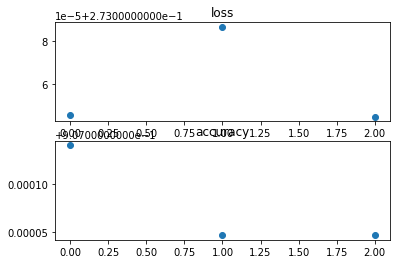

0.2729747271151495 tensor([0.9068])


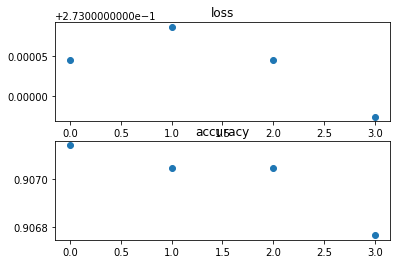

0.272978059956849 tensor([0.9065])


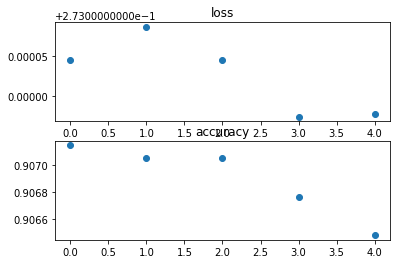

0.2728466613249805 tensor([0.9063])


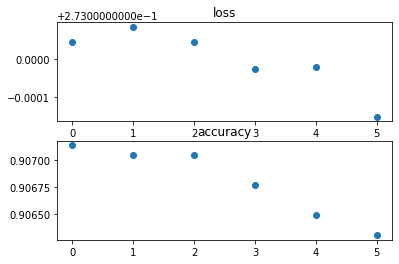

0.27298045183693254 tensor([0.9070])


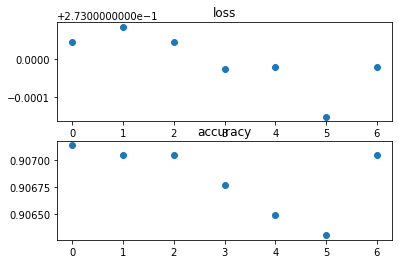

0.2729258102032381 tensor([0.9074])


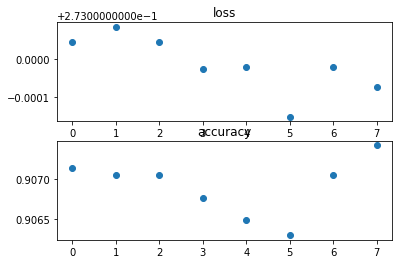

0.2728307427639215 tensor([0.9072])


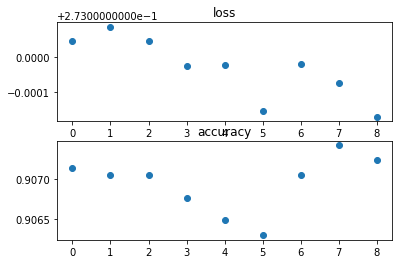

0.27287849513017765 tensor([0.9068])


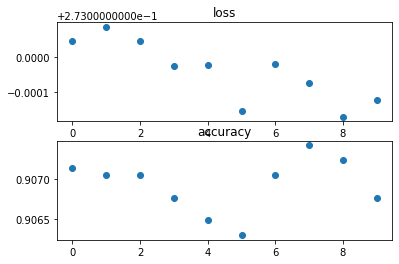

In [40]:
learning_rate = 0.01
n_iters = 10

optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
dataset = TensorDataset(Xtrain, Ytrain)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
loss_list = []
acc_list = []
path = 'model.pt'

for epoch in range(n_iters):
  total_loss = 0
  for x, y in loader:
    optimizer.zero_grad()
    loss_value = loss(nn_model(x),y)
    loss_value.backward()
    optimizer.step()
    total_loss += loss_value.item()
  loss_point = total_loss/len(loader)
  acc_point = acc(loader,model)
  loss_list.append(loss_point)
  acc_list.append(acc_point)
  
  # checkpoint write out
  torch.save({
            'epoch': epoch,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_point,
            }, path)
  
  # display output
  print(loss_point, acc_point)
  fig, axs = plt.subplots(2)
  axs[0].set_title('loss')
  axs[0].scatter(range(epoch+1), loss_list)
  axs[1].set_title('accuracy')
  axs[1].scatter(range(epoch+1), acc_list)
  plt.show()

## 77. ミニバッチ化

In [50]:
learning_rate = 0.01
n_iters = 10

optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
dataset = TensorDataset(Xtrain, Ytrain)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
loss_list = []
acc_list = []
batches = [2**x for x in range(n_iters)]
time_list = []

for batch in batches:
  total_loss = 0
  dataset = TensorDataset(Xtrain, Ytrain)
  loader = DataLoader(dataset, batch_size=batch, shuffle=True)
  start_time = time.time()
  for x, y in loader:
    optimizer.zero_grad()
    loss_value = loss(nn_model(x),y)
    loss_value.backward()
    optimizer.step()
    total_loss += loss_value.item()
  time_list.append(time.time()-start_time)

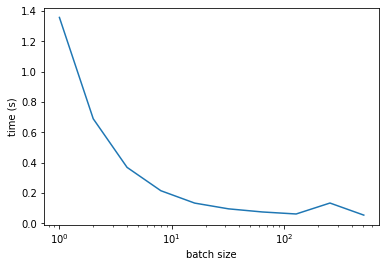

In [51]:
plt.plot(batches, time_list)
plt.xscale('log')
plt.xlabel('batch size')
plt.ylabel('time (s)')
plt.show()

## 78. GPU上での学習

In [54]:
learning_rate = 0.01
n_iters = 10

optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
dataset = TensorDataset(Xtrain, Ytrain)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
loss_list = []
acc_list = []
batches = [2**x for x in range(n_iters)]
time_list_gpu = []

for batch in batches:
  total_loss = 0
  dataset = TensorDataset(Xtrain, Ytrain)
  loader = DataLoader(dataset, batch_size=batch, shuffle=True)
  start_time = time.time()
  for x, y in loader:
    if torch.cuda.is_available():
      print('using GPU')
      x, y = x.to('cuda'), y.to('cuda')
    optimizer.zero_grad()
    loss_value = loss(nn_model(x),y)
    loss_value.backward()
    optimizer.step()
    total_loss += loss_value.item()
  time_list_gpu.append(time.time()-start_time)

In [ ]:
plt.plot(batches, time_list_gpu)
plt.xscale('log')
plt.xlabel('batch size')
plt.ylabel('time (s)')
plt.show()

## 79. 多層ニューラルネットワーク

In [59]:
class NeuralNetworkMulti(nn.Module):
  def __init__(self, input_size, output__middle_size, output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, output__middle_size, bias=True)
    self.fc2 = nn.Linear(output__middle_size, output__middle_size, bias=True)
    self.fc3 = nn.Linear(output__middle_size, output_size, bias=True)
  
  def forward(self, x):
    l1 = F.relu(self.fc1(x))
    l2 = F.relu(self.fc2(l1))
    x = self.fc3(l2)
    return x

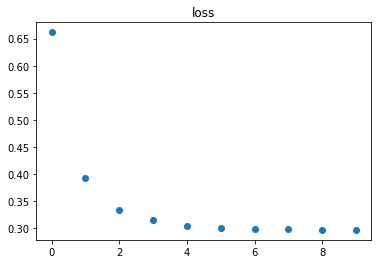

In [65]:
nn_model_multi = NeuralNetworkMulti(300, 100, 4)

learning_rate = 0.01
n_iters = 10

optimizer = optim.SGD(nn_model_multi.parameters(), lr=learning_rate)
dataset = TensorDataset(Xtrain, Ytrain)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
loss_list = []
acc_list = []
batches = [2**x for x in range(n_iters)]
time_list = []

for batch in batches:
  total_loss = 0
  dataset = TensorDataset(Xtrain, Ytrain)
  loader = DataLoader(dataset, batch_size=batch, shuffle=True)
  start_time = time.time()
  for x, y in loader:
    if torch.cuda.is_available():
      print('using GPU')
      x, y = x.to('cuda'), y.to('cuda')
    optimizer.zero_grad()
    loss_value = loss(nn_model_multi(x),y)
    loss_value.backward()
    optimizer.step()
    total_loss += loss_value.item()
  loss_point = total_loss/len(loader)
#   acc_point = acc(loader,model)
  loss_list.append(loss_point)
#   acc_list.append(acc_point)
  time_list.append(time.time()-start_time)

# display output
plt.title('loss')
plt.scatter(range(epoch+1), loss_list)
plt.show()